# Multiple Sequence Alignment using Multi-objective Genetic Algorithms

### Authors:
1. Urvish Vasani - uvasani
2. Kenil Shah - kshah9
3. Suraj Patel - sjpate22
4. Priyanka Hebsur - phebsur

### Install external dependencies
Execute this block below to install required libraries

In [1]:
import Pkg
Pkg.add("FASTX")
Pkg.add("Distributions")
Pkg.add("BioSequences")
Pkg.add("Plots")

using FASTX
using Distributions
using BioSequences
using Random
using Plots

   Updating registry at `C:\Users\ur207\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\ur207\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\ur207\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\ur207\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\ur207\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\ur207\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\ur207\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\ur207\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\ur207\.julia\environments\v1.5\Manifest.toml`


## 1. Chromosome Codification

<hr>

## Function: codify_chromosome
This function takes an individual which is list of strings(sequence) and converts into a encoded form. For efficiently implementing the crossover operator and mutation operator, this approach represents alignments as a two-dimensional matrix where each row stands for each alignment and includes the following two conditions: 
* amino acids are coded with their position in the sequence where they belong
* gaps are coded with the ‘negative’ position of the last amino acid in the sequence

### Input :
* msa (List of sequences)

### Output :
* chromosom (Encoded MSA)


In [2]:
function codify_chromosome(msa)
    chromosome = [[0 for j in 1:length(msa[1])] for i in 1:length(msa)] 
    for i in 1:length(msa)
        count = 0
        for j in 1:length(msa[i])
            if msa[i][j] == '-'
                chromosome[i][j] = count*(-1) 
            else
                count = count + 1
                chromosome[i][j] = count
            end
        end
    end
    
    return chromosome
end
#codify_chromosome(["ABCDEFGH--","AB----CDEF","ABCD----EF"])


codify_chromosome (generic function with 1 method)

## 2. Helper Functions
<hr>

## function: remove_columns_with_all_gaps
This function is used to remove the columns with all gaps and no nucleotides. This can happen as a side effect of the crossover and mutation operations.

### Input:
* sequences (Alignments having columns with gaps)
* codifications (Alignment codification)

### Output:
* sequences (Alignments without any column having all gaps)
* codifications (Modified codification)

In [3]:
function remove_columns_with_all_gaps(sequences, codifications)
    columns_with_all_gaps = []
    total_seq = length(sequences)
    
    for (index,nucleotide) in enumerate(sequences[1])
        if nucleotide == '-'
            column_with_all_gaps = true
            
            for i in 2:total_seq
                if sequences[i][index] != '-'
                    column_with_all_gaps = false
                    break
                end
            end
            
            if column_with_all_gaps
                append!(columns_with_all_gaps, index)
            end
        end
    end
    
    for i in 1:total_seq
        sequences[i] = join([c for (i,c) in enumerate(sequences[i]) if ~(i in columns_with_all_gaps)])
        codifications[i] = [c for (i,c) in enumerate(codifications[i]) if ~(i in columns_with_all_gaps)]
    end
                    
    return sequences, codifications
end
                                
#remove_columns_with_all_gaps(["ab---fg","ab---fg","ab-c-fg","ab---fg"], [[1,2,-2,-2,-2,3,4],[1,2,-2,-2,-2,3,4],[1,2,-2,3,-3,4,5],[1,2,-2,-2,-2,3,4]])


remove_columns_with_all_gaps (generic function with 1 method)

## 3. Crossover Operation

---

## function: get_cut_point
This function would take in the elements found after the cut and the encoded version of the sequence and it would return us the cut_point index for the encoded sequence

### Input:
* cut_elements (Elements which are found at the cut point for string 1)
* chromosome_coded (Encoded sequence of string 2)

### Output:
* cut_point: (Cut point index for string 2)

***

## function: crossover
This function would take two parent candidate strings and there encoded version in order to generate two children by using the strategy of crossover. In crossover the cut elements of both the candidates are matched and then children are generated by merging left/right and right/left part of the both the parents.

### Input:
* chromosome_string1 (Parent 1 which will have a list of sequence strings)
* chromosome_string2 (Parent 2 which will have a list of sequence strings)
* chromosome_coded1  (Encoded version of first parent)
* chromosome_coded2  (Encoded version of second parent)

### Output:
* crossover_string (Two child strings generated by two different combination of pairs)
* crossover_coded  (Two encoded version of the children)

In [4]:
function get_cut_point(cut_elements,chromosome_coded)
    cut_point = 0
    for i in 1:length(chromosome_coded)
        if abs(chromosome_coded[i])==abs(cut_elements[1])
            cut_point = i
            break
        end
    end
    return cut_point
end

function crossover(chromosome_string1, chromosome_coded1,chromosome_string2, chromosome_coded2)
    minimum = min(length(chromosome_string1[1]), length(chromosome_string2[1]))
    cut_point = rand(2:minimum-1)

    diff1,diff2 = Inf,-Inf
    
    cut_points_string2 = []
    
    for i in 1:length(chromosome_string1)
        cut_elements =  [chromosome_coded1[i][cut_point],chromosome_coded1[i][cut_point+1]]
        cut_point2 = get_cut_point(cut_elements,chromosome_coded2[i])
        diff1 = min(diff1,cut_point2)
        diff2 = max(diff2,cut_point2)
        push!(cut_points_string2,cut_point2)
    end
    
    crossover_string = [[],[]]
    crossover_coded = [[],[]]
    
    for i in 1:length(chromosome_string1)
        cut_point2 = cut_points_string2[i]
        s1 = chromosome_string1[i][1:cut_point]
        s2 = chromosome_string2[i][cut_point2+1:length(chromosome_string2[i])]
        
        gap_count1 = Int(cut_point2 - diff1)
        gaps1 = "-"^gap_count1
        
        main_string1 = string(s1,gaps1,s2)        
        main_coded1 = codify_chromosome([main_string1])[1]
        
        s1 = chromosome_string2[i][1:cut_point2]
        s2 = chromosome_string1[i][cut_point+1:length(chromosome_string1[i])]

        gap_count2 = Int(diff2 - cut_point2)
        gaps2 = "-"^gap_count2

        main_string2 = string(s1,gaps2,s2)        
        main_coded2 = codify_chromosome([main_string2])[1]
        
        push!(crossover_string[1], main_string1)
        push!(crossover_coded[1], main_coded1)
        
        push!(crossover_string[2], main_string2)
        push!(crossover_coded[2], main_coded2)
    end
    crossover_string[1],crossover_coded[1] = remove_columns_with_all_gaps(crossover_string[1],crossover_coded[1])
    crossover_string[2],crossover_coded[2] = remove_columns_with_all_gaps(crossover_string[2],crossover_coded[2])

    return crossover_string,crossover_coded
    
end

#crossover(["ACGTT--AC-G-GG-", "A-GGCTTTAGG-CG-", "AG-G-CT-ATGCAGG"],[[1, 2, 3, 4, 5, -5, -5, 6, 7, -7, 8, -8, 9, 10, -10], [1, -1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -10, 11, 12, -12], [1, 2, -2, 3, -3, 4, 5, -5, 6, 7, 8, 9, 10, 11, 12]],["AC--G--TTA-CGGG", "AGGC-T-T-TAGGCG", "A-GGCTATGC-A-GG"],[[1, 2, -2, -2, 3, -3, -3, 4, 5, 6, -6, 7, 8, 9, 10], [1, 2, 3, 4, -4, 5, -5, 6, -6, 7, 8, 9, 10, 11, 12], [1, -1, 2, 3, 4, 5, 6, 7, 8, 9, -9, 10, -10, 11, 12]])

crossover (generic function with 1 method)

## 4. Mutation Operation

<hr>

## function: mutation

This function takes an individual alignment and its codification as input and generated the offspring. For our algorithm, mutation operator moves the group of gaps from one position to other in order to generate the offspring.

### input:
* parent_sequence (parent consists of the list of strings)
* parent_alignment (codification of the parent_sequence)

### output:
* child_sequence (Generated Offspring as mentioned above)
* child_codification (codification of the generated child)

In [5]:
function mutation(parent_sequence, parent_codification)
    child_sequence = []
    child_codification = []
    
    for i in 1:length(parent_codification)
        curr_codification = parent_codification[i]
        curr_sequence = parent_sequence[i]
        
        gaps = []
        gap_start = -1
        for j in 1:length(curr_sequence)
            if curr_sequence[j] == '-'
                if gap_start == -1
                    gap_start = j
                end
            else
                if gap_start != -1
                    push!(gaps,[gap_start,j-1])
                    gap_start = -1
                end
            end
        end
        if gap_start != -1
            push!(gaps,[gap_start,length(curr_sequence)])
        end
        
        if length(gaps) == 0
            mutated_seq = join([c for (i,c) in enumerate(curr_sequence)])
            mutated_codification = [c for (i,c) in enumerate(curr_codification)]
            
            push!(child_sequence, mutated_seq)
            push!(child_codification, mutated_codification)
            
            continue
        end
        
        gap_group = gaps[rand(1:length(gaps))]
        
        mutated_seq = join([c for (i,c) in enumerate(curr_sequence) if ~(i>=gap_group[1] && i<=gap_group[2])])
        mutated_codification = [c for (i,c) in enumerate(curr_codification) if ~(i>=gap_group[1] && i<=gap_group[2])]
                        
        target_position = rand(1:length(mutated_seq)+1)
        
        gap_sequence = join(['-' for i in gap_group[1]:gap_group[2]])
        
        if target_position == length(mutated_seq)+1
            mutated_seq = mutated_seq * gap_sequence
            gap_code = -1*abs(mutated_codification[length(mutated_codification)])
            mutated_codification = cat(mutated_codification,[gap_code for i in gap_group[1]:gap_group[2]], dims=1)
        elseif target_position == 1
            mutated_seq = gap_sequence * mutated_seq
            gap_code = 0
            mutated_codification = cat([gap_code for i in gap_group[1]:gap_group[2]], mutated_codification, dims=1)
        else
            mutated_seq = mutated_seq[1:target_position-1] * gap_sequence * mutated_seq[target_position:length(mutated_seq)]
            gap_code = -1*abs(mutated_codification[target_position-1])
            mutated_codification = cat(mutated_codification[1:target_position-1],[gap_code for i in gap_group[1]:gap_group[2]],mutated_codification[target_position:length(mutated_codification)],dims=1)          
        end
                                    
        push!(child_sequence, mutated_seq)
        push!(child_codification, mutated_codification)
    end
    
    child_sequence,child_codification = remove_columns_with_all_gaps(child_sequence, child_codification)
end

#mutation(["abcd---cd--ef-cde-", "abcd---cd--ef-cdef"], [[1,2,3,4,-4,-4,-4,5,6,-6,-6,7,8,-8,9,10,11,-11],[1,2,3,4,-4,-4,-4,5,6,-6,-6,7,8,-8,9,10,11,12]])


mutation (generic function with 1 method)

## 5. Initial Population Generation
***

## Function: add_initial_gaps
This function simply adds gaps to a sequence

### Input :
* Gap Count (No. of gaps to be added)
* Single Sequence

### Output :
* Sequence with gaps in it

---
## Function: generate_single_chromosome
This function would take in the multiple sequences and will try to add some number of gaps to every sequence by following
the below mentioned instructions:
* Find the sequence with maximum length in the multiple sequennces
* Add gaps ranging from randomly 20-40% in this specific sequence
* Since we have to make every sequence of same length, we would compute the number of gaps needed to add in every sequence
to make it similar to the sequence with maximum length.

### Input :
* Chromosome (Multiple Sequence)

### Output :
* Chromosome (Multiple Sequences with gaps added to them)

***

## Function: generate_initial_population
This function generates a set of chromosomes after adding gaps to given initial sequence. After adding 20% of chromosomes with gaps in it, we would crossover those sequences in order to generate other 80% of chromosomes. This set of chromosomes would be our initial population.

### Input :
* Chromosome (Multiple Sequence)
* population_count (Number of chromosomes for initial population)

### Output :
* population_string (Will contain population_count number of candidates)
* population_coded  (Will contain population_count number of encoded candidates)

In [6]:
function add_initial_gaps(gap_count,sequence)
    gap_count = floor(gap_count)
    while gap_count!=0
        blank_count = Int(rand(1:gap_count))
        position  = rand(1:length(sequence))
        sequence = string(sequence[1:position],"-"^blank_count,sequence[position+1:length(sequence)])
        gap_count=gap_count-blank_count
    end
    return sequence
end

function generate_single_chromosome(msa)
    
    new_msa = []
    for i in 1:length(msa)
        push!(new_msa,"")
    end
    
    max_sequence_length = length(msa[1])
    max_sequence_index = 1
    for (i,sequence) in enumerate(msa)
        if length(sequence)>max_sequence_length
            max_sequence_length = length(sequence)
            max_sequence_index = i
        end
    end
    
    # Update Max Length Sequence
    
    gap_count = rand(Uniform(0.2,0.4)) * max_sequence_length
    new_msa[max_sequence_index] = add_initial_gaps(gap_count,msa[max_sequence_index])
    
    # Update Rest of the Sequences
    
    for i in 1:length(msa)
        if i==max_sequence_index
            continue
        end
        gap_counts = length(new_msa[max_sequence_index]) - length(msa[i])
        new_msa[i] = add_initial_gaps(gap_counts,msa[i])
    end
    return new_msa
end

function generate_initial_population(msa,population_count)        
    without_crossover = 0.2*population_count
    population_string = []
    population_coded = []
    for i in 1:without_crossover
        chromosome = generate_single_chromosome(msa)
        coded_chromosome = codify_chromosome(chromosome)
        chromosome,coded_chromosome = remove_columns_with_all_gaps(chromosome,coded_chromosome)
        push!(population_coded,coded_chromosome)
        push!(population_string,chromosome)
    end
        
    with_crossover = (0.8*population_count)/2
    for i in 1:with_crossover
        random1 = Int(rand(1:without_crossover))
        random2 = Int(rand(1:without_crossover))
        crossover_string, crossover_coded = crossover(population_string[random1],population_coded[random1],population_string[random2],population_coded[random2])
        population_string = vcat(population_string,crossover_string)
        population_coded = vcat(population_coded,crossover_coded)
    end
    return population_string, population_coded
end    

#generate_initial_population(["ACGTTACCCGGAAATTTTTTACGGG","ACGTTACCTGGGAATATTGTACAGG","GTGTAAGGTGGGAATATTTFAGAGG"],100)

generate_initial_population (generic function with 1 method)

# 6. Fitness functions
***

## Function : compute_tc_score
Given an input sequence, this function calculates the percentage of columns which are completely aligned with same amino acids. 

### Input:
* sequences (individual alignment)

### Output:
* score (Percentage of totally consered columns)

***

## Function : calc_sum_pair
Given an input sequence, this function returns the sum of pairwise alignment score. Bonus for match is 1, mismatch penalty is zero and Gap penalty is zero.

### Input:
* sequences (individual alignment)

### Output:
* score (Percentage of totally consered columns)

***

## Function : calc_nogap_percentage
In order to penalize overuse of gaps in the produced alignment, this function calculates the percentage of amino acids in the given alignment as compared to the number of gaps.

### Input:
* sequences (individual alignment)

### Output:
* no_gaps_score (Percentage of totally consered columns)


In [7]:
function compute_tc_score(sequences)
    no_of_aligned_columns = 0
    total_columns = length(sequences[1])
    is_aligned = true
    for i in 1:total_columns
        is_aligned = true
        first_residue= sequences[1][i]
        if  first_residue != '-'
            for j in 1:length(sequences)
                if first_residue != sequences[j][i]
                    is_aligned = false
                    break
                end
            end
            else is_aligned = false
        end
        if is_aligned 
            no_of_aligned_columns += 1
        end
    end
    score = (100.0 * no_of_aligned_columns) / total_columns
    return score 
end

# +1 for match and 0 for no match

function calc_sum_pair(sequences) 
    t = length(sequences)
    k = length(sequences[1])
    score = 0
    for i=1:t
        A = sequences[i]
        for j=i+1:t
            B = sequences[j]
            for idx = 1:k
                if A[idx] == B[idx] && A[idx] != '-'
                    score += 1
                end
            end
        end
    end
    return score
end

function calc_nogap_percentage(sequences)
    t = length(sequences)
    k = length(sequences[1])
    no_gaps = 0
    for i in 1:t
        for j in 1:k
            if sequences[i][j]!='-'
                no_gaps+=1
            end
        end
    end
    total = k*t
    no_gaps_score = (no_gaps/total)*100
    return no_gaps_score
end
    
# +1 match. -1 mismatch and -2 for gaps
function calc_sum_pair2(sequences) 
    t = length(sequences)
    k = length(sequences[1])
    score = 0
    for i=1:t
        A = sequences[i]
        for j=i+1:t
            B = sequences[j]
            for idx = 1:k
                if A[idx]=='-' || B[idx]=='-'
                    score -=2
                elseif A[idx] == B[idx]
                    score += 1
                else
                    score -= 1
                end
            end
        end
    end
    return score
end

function calculate_fitness_score(align)
    return [compute_tc_score(align), calc_sum_pair(align), calc_nogap_percentage(align), calc_sum_pair2(align)]
end
#Test 
#sequences = ["AGGCTTT-A-C", "CCCAGTG-AT-","GGCFATT-AT-"]
#print(calculate_fitness_score(sequences))

calculate_fitness_score (generic function with 1 method)

## 7. NSGA-II algorithm for multi-objectve optimization

***
Reference: https://github.com/gsoleilhac/NSGAII.jl 
Matlab implementation of the paper used inbuilt functioalities to execute NSGA-II. Since there is no such reliable support present in julia, we implemented our own with the help of references mentioned above.

***

## Structure: Individual
This structure is used to store the information about each individual in the current population. In particular, following information is stored:
* align : list of string representing the alignment
* codification : codification of the alignment present in the align
* y : list of fitness score values
* rank : rank of the pareto front assigned to this individual
* crowding : crowding distance for this individual
* dom_count : Number of individuls that dominated this particular individual
* dom_list : list of individuals dominated by this individual

***

## Function: dominates
This function returns whether first individual dominate the other in terms of fitness scores.

### input
* a : First individual
* b : Seconf individual

### output
* result : true if first individual dominates the other and false otherwise

***

## Function: isless
This function returns whether the rank of the first individual is lower than the other. In case where rank of both the individuals are the same, crowding distace is used.

### input
* a : First individual
* b : Seconf individual

### output
* result : true if rank of the first individual is lower than the second

In [8]:
# Basic structure to store the individuals and helper functions

mutable struct Individual{Align, Codification, Fitness}
    align::Align
    codification::Codification
    y::Fitness
    rank::UInt16
    crowding::Float64
    dom_count::UInt16
    dom_list::Vector{UInt16}
    
    Individual(align::Align, codification::Codification ,y::Fitness) where {Align,Codification,Fitness} = new{Align,Codification,Fitness}(align, codification, y,zero(UInt16),0.,zero(UInt16),UInt16[]) 
end

function dominates(a::Individual, b::Individual)
    result = false
    for i in eachindex(a.y)
        a.y[i] < b.y[i] && return false
        a.y[i] > b.y[i] && (result = true)
    end
    return result
end

function isless(a::Individual, b::Individual)
    return a.rank < b.rank || a.rank == b.rank && a.crowding >= b.crowding
end


isless (generic function with 1 method)

## Function: calculate_Pareto_Fronts!
This function graphs the pareto front on the individuals present inside population and assigns rank to each individual as well according to the front in which they belong.

### Input
* population : List of Individuals present in the current population

### Output
* This function does not return anything but assigns the ranks to the individuals in-place.

In [9]:
function calculate_Pareto_Fronts!(population)
    n = length(population)
    for p in population
        empty!(p.dom_list)
        p.dom_count = 0
        p.rank = 0
    end
    
    ranked_individuals = 0
    
    current_rank_index = []
    for i in 1:n
        for j in i+1:n
            if dominates(population[i], population[j])
                push!(population[i].dom_list, j)
                population[j].dom_count += 1
            elseif dominates(population[j], population[i])
                push!(population[j].dom_list, i)
                population[i].dom_count += 1
            end
        end
        if population[i].dom_count == 0
            population[i].rank = 1
            ranked_individuals += 1
            append!(current_rank_index, i)
        end
    end
    
    current_rank = UInt16(2)
    while ranked_individuals != n
        indiv_to_delete = deepcopy(current_rank_index)
        empty!(current_rank_index)
        
        for i in indiv_to_delete
            p = population[i]

            for q in p.dom_list
                population[q].dom_count -= one(UInt16)
                if population[q].dom_count == zero(UInt16)
                    population[q].rank = current_rank
                    ranked_individuals += 1
                    append!(current_rank_index, q)
                end
            end

        end
        current_rank += one(UInt16)        
    end
    
    #=
    current_rank = UInt16(2)
    while ranked_individuals != n
       for p in population
            if rank == current_rank - one(UInt16)
                for q in p.dom_list
                    population[q].dom_count -= one(UInt16)
                    if population[q].dom_count == zero(UInt16)
                        population[q].rank = k
                        ranked_individuals += 1
                    end
                end
            end
        end
        k += one(UInt16)
    end
    =#
end

calculate_Pareto_Fronts! (generic function with 1 method)

## Function: tournament_selection
This function randomly samples two individuals from the whole population and returns the one with lower rank and higher crowding distance.

### input
* P : population of individuals

### output
* Individual : returns the individual sampled from the above mentioned approach.

In [10]:
function tournament_selection(P)
    a,b = rand(1:length(P)÷2), rand(1:length(P)÷2)
    if isless(P[a], P[b])
        return P[a]
    else
        return P[b]
    end
end

tournament_selection (generic function with 1 method)

## Function: crowding_distance_sorting!
This function computed the crowding distance for the population passed as the input and assigns distance value to each individuals present inside the population.

### Input
* population : List of Individuals present in the current population

### Output
* This function does not return anything but assigns the crowding distance to the individuals in-place.

In [11]:
function crowding_distance_sorting!(population)
    for p in population
        p.crowding = 0.
    end
    for j = 1:length(first(population).y)
        sort!(population, by = x -> x.y[j])
        population[1].crowding = population[end].crowding = Inf
        if population[1].y[j] != population[end].y[j]
            for i in 2:length(population)-1
                population[i].crowding += (population[i+1].y[j] - population[i-1].y[j]) / (population[end].y[j] - population[1].y[j])
            end
        end
    end
end

crowding_distance_sorting! (generic function with 1 method)

## Function: NSGA
This function executes the discussed NSGA approach on the provided input sequence.

### Input
* input_seq : Input alignments
* population_size : size of the population
* num_of_gen : number of generations
* pmut : probability of mutation

### steps
* From the provided input sequence, initial population of population_size is generated
* For this initial population, pareto fronts are generated and assigned ranks as well.
* Now, for each generation, population is doubled using crossover and mutation operations. Then, pareto front is generated and best individuals are included in the next population.
* At the end, best individual from the first pareto front is returned.

### output
* best_sol : Individual with best alignment score.

In [12]:
function NSGA(input_seq, population_size, num_of_gen, pmut)
    alignments, codes = generate_initial_population(input_seq, population_size)
    
    P = Vector{Individual}(undef, 2*population_size)    # Whole population 
    
    for i in 1:population_size                                # Create Initial population
        P[i] = Individual(alignments[i],codes[i], calculate_fitness_score(alignments[i])) 
        P[population_size+i] = deepcopy(P[i])
    end
    
    calculate_Pareto_Fronts!(view(P, 1:population_size))
    
    for gen in 1:num_of_gen
        for i = 1:2:population_size
            
            pa = tournament_selection(P)
            pb = tournament_selection(P)
            
            childs_align, childs_codification = crossover(pa.align, pa.codification, pb.align, pb.codification)
            
            if rand() < pmut
                childs_align[1],childs_codification[1] = mutation(childs_align[1],childs_codification[1])
            end
                
            if rand() < pmut
                childs_align[2], childs_codification[2] = mutation(childs_align[2],childs_codification[2])
            end
            
            P[population_size+i] = Individual(childs_align[1],childs_codification[1], calculate_fitness_score(childs_align[1])) 
            P[population_size+i+1] = Individual(childs_align[2],childs_codification[2], calculate_fitness_score(childs_align[2])) 
            
        end
        calculate_Pareto_Fronts!(P)
        
        sort!(P, by = x -> x.rank, alg = Base.Sort.QuickSort)
        
        let f::Int = 1
            ind = 0
            indnext = findlast(x -> x.rank == f, P)
            while 0 < indnext <= population_size
                ind = indnext
                f += 1
                indnext = findlast(x -> x.rank == f, P)
            end
            indnext == 0 && (indnext = length(P))
            crowding_distance_sorting!(view(P, ind+1:indnext))
            sort!(view(P, (ind + 1):indnext), by = x -> x.crowding, rev = true, alg = PartialQuickSort(population_size - ind))
            
        end
        
    end
    optimal_sols = filter(x -> x.rank == 1, view(P, 1:population_size))
    
    best_sol = optimal_sols[1]
    for i in 2:length(optimal_sols)
        if optimal_sols[i].y[2] > best_sol.y[2]
             best_sol = optimal_sols[i]
        end 
    end
    
    return best_sol
    
end

#input_seq = ["AATGGTCATAGCGAGATGAAGCCACGTGATGGATAATATTGTGCAAACGACCTTATTAGCTATTGACCGTCGATGTCCAACGAGACAATT", "GAATCTGTATTCTTCAAGCTTCAACTCCATGCACTACGAACGGTAGTGGTTCACATTGACCGTG", "TTGGGCGCATTGACCGTCCTTCCTAGCGTATCATCAAACTTGTGATTCTCTATCTAGAGCAAAATGCGGTGTCCGCTATATGGAGATCTATTTCAAAATA", "GTTACATATCAGAATCATTAGAAACGCTCTTAATGGGGTTAAGCAGAGACTTAGTAAGGATTAACTCCCAAGATGATTGACCGTGCTC"]
#NSGA(input_seq,100,300,0.8)

NSGA (generic function with 1 method)

## 8. reading input from the file

***

## Function: read_input

this function reads file with input sequences in the FASTA format and returns the identifiers and sequences.

### Input
* filename : name of the input file

### Output
* identifiers : list of identifiers 
* sequences : list of input sequences

In [13]:
# Read sequences from the input file
# Reference: https://biojulia.net/FASTX.jl/dev/manual/fasta/

function read_input(filename)
    reader = open(FASTA.Reader, filename)
    
    identifiers = []
    sequences = []
    
    for record in reader
        push!(identifiers, string(FASTA.identifier(record)))
        push!(sequences, string(FASTA.sequence(record)))
    end
    close(reader)
    
    return identifiers, sequences
end
#read_input("input1.txt")


read_input (generic function with 1 method)

## 9. Main function

driver function implemented below reads input sequences from the "input1.txt" file, executes the NSGA algorithm and stores the optimal alignments back to the "outout1.txt" file.

In [67]:
function driver()
    identifiers, sequences = read_input("input1.txt")
    population_size = 200
    num_of_generations = 500
    mutation_prob = 0.8
    
    optimal_individual = NSGA(sequences, population_size, num_of_generations, mutation_prob)
    optimal_align = optimal_individual.align
    score = optimal_individual.y[2]
    
    println("Input sequences:")
    for each in sequences
        println(each)
    end
    println()
    println("Generated alignments:")
    for each in optimal_align
        println(each)
    end
    println()
    println("Sum of pairs scor[+1 for match, 0 otherwise]: ", score) 
    println()
    
    println("This alignment is stored in the output1.txt file")
    
    w = open(FASTA.Writer, "output1.txt")
    for i in 1:length(optimal_align)
        rec = FASTA.Record(identifiers[i], optimal_align[i])
        write(w, rec)
    end
    close(w)
end
driver()

Input sequences:
AATGGTCATAGCGAGATGAAGCCACGTGATGGATAATATTGTGCAAACGACCTTATTAGCTATTGACCGTCGATGTCCAACGAGACAATT
GAATCTGTATTCTTCAAGCTTCAACTCCATGCACTACGAACGGTAGTGGTTCACATTGACCGTG
TTGGGCGCATTGACCGTCCTTCCTAGCGTATCATCAAACTTGTGATTCTCTATCTAGAGCAAAATGCGGTGTCCGCTATATGGAGATCTATTTCAAAATA
GTTACATATCAGAATCATTAGAAACGCTCTTAATGGGGTTAAGCAGAGACTTAGTAAGGATTAACTCCCAAGATGATTGACCGTGCTC

Generated alignments:
AATGGT-CATAGCGAGATGAAGCC-ACGT-GATGGAT-AATATTGTGCAAACGACCTTATT--AGCTATT----------GACCGTCGATGTCCAACGAGACAATT
GAATCTGTATT-CTTCAAGCTTCA-ACTC-CATGCA------CTACGAA---------------------------------CGGTAGTGGTTCACATTGACCGTG
TTGGGCGCATT-GACCGTCCTTCCTA-GCGTAT-CATCAAACTTGTG-ATTCTC--TATCTAGAGCAAAATGCGGTGTCCGCTATATGGAGATCTATTTCAAAATA
GTTA-CATATCAGAATCATTAGAA-ACGC-TCTTAAT-GGGGTTAAGCAGA-GAC-TTAGTA-AGGATTAA---------CTCCCAAGATGATTGACCGTGC--TC

Sum of pairs scor[+1 for match, 0 otherwise]: 184.0

This alignment is stored in the output1.txt file


## Algorithm performance experiments

***

In [49]:
function generate_dna_sequences(t,l)
    dna_sequences=[]
    for i in 1:t
        dna=randstring("AGTC", l)
        push!(dna_sequences,dna)
    end
    return dna_sequences
end

generate_dna_sequences (generic function with 1 method)

In [51]:
function NSGA_Experiment(input_seq, population_size, num_of_gen, pmut)
    alignments, codes = generate_initial_population(input_seq, population_size)
    P = Vector{Individual}(undef, 2*population_size)    # Whole population 
    for i in 1:population_size                                # Create Initial population
        P[i] = Individual(alignments[i],codes[i], calculate_fitness_score(alignments[i])) 
        P[population_size+i] = deepcopy(P[i])
    end
    calculate_Pareto_Fronts!(view(P, 1:population_size))
    generations=[]
    align_score=[]
    for g in 50:20:250
        append!(generations,g)
    end
    for gen in 1:num_of_gen
        for i = 1:2:population_size
            pa = tournament_selection(P)
            pb = tournament_selection(P)
            childs_align, childs_codification = crossover(pa.align, pa.codification, pb.align, pb.codification)
            if rand() < pmut
                childs_align[1],childs_codification[1] = mutation(childs_align[1],childs_codification[1])
            end
            if rand() < pmut
                childs_align[2], childs_codification[2] = mutation(childs_align[2],childs_codification[2])
            end
            P[population_size+i] = Individual(childs_align[1],childs_codification[1], calculate_fitness_score(childs_align[1])) 
            P[population_size+i+1] = Individual(childs_align[2],childs_codification[2], calculate_fitness_score(childs_align[2])) 
        end
        calculate_Pareto_Fronts!(P)
        sort!(P, by = x -> x.rank, alg = Base.Sort.QuickSort)
        let f::Int = 1
            ind = 0
            indnext = findlast(x -> x.rank == f, P)
            while 0 < indnext <= population_size
                ind = indnext
                f += 1
                indnext = findlast(x -> x.rank == f, P)
            end
            indnext == 0 && (indnext = length(P))
            crowding_distance_sorting!(view(P, ind+1:indnext))
            sort!(view(P, (ind + 1):indnext), by = x -> x.crowding, rev = true, alg = PartialQuickSort(population_size - ind))
        end
        if gen in generations
            optimal_sols = filter(x -> x.rank == 1, view(P, 1:population_size))
            best_sol = optimal_sols[1]
            for i in 2:length(optimal_sols)
                if optimal_sols[i].y[2] > best_sol.y[2]
                     best_sol = optimal_sols[i]
                end 
            end
            append!(align_score,best_sol.y[2])
        end
    end
    return generations, align_score
end
#input_seq = ["AATGGTCATAGCGAGATGAAGCCACGTGATGGATAATATTGTGCAAACGACCTTATTAGCTATTGACCGTCGATGTCCAACGAGACAATT", "GAATCTGTATTCTTCAAGCTTCAACTCCATGCACTACGAACGGTAGTGGTTCACATTGACCGTG", "TTGGGCGCATTGACCGTCCTTCCTAGCGTATCATCAAACTTGTGATTCTCTATCTAGAGCAAAATGCGGTGTCCGCTATATGGAGATCTATTTCAAAATA", "GTTACATATCAGAATCATTAGAAACGCTCTTAATGGGGTTAAGCAGAGACTTAGTAAGGATTAACTCCCAAGATGATTGACCGTGCTC"]
#NSGA(input_seq,100,300,0.8)

NSGA_Experiment (generic function with 1 method)

## Plot Graphs

**Plot 1:** Time taken by NSGA 2 algorithm with respect to number of generations.

**Plot 2:** Resulting alignment score by NSGA 2 algorithm with respect to number of generations.

**Plot 3:** Time taken by NSGA 2 algorithm with respect to number of sequences.

**Plot 4:** Memory consumed by NSGA 2 algorithm with respect to number of sequences.

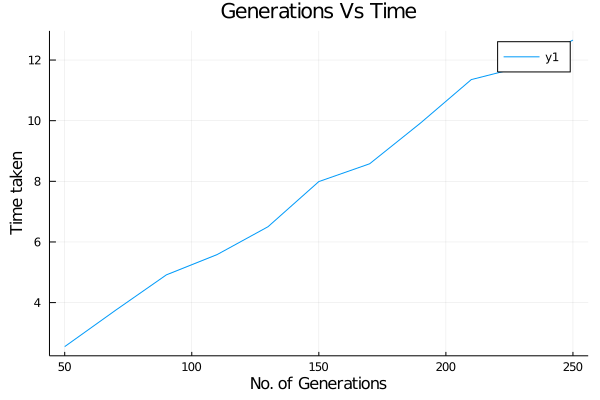

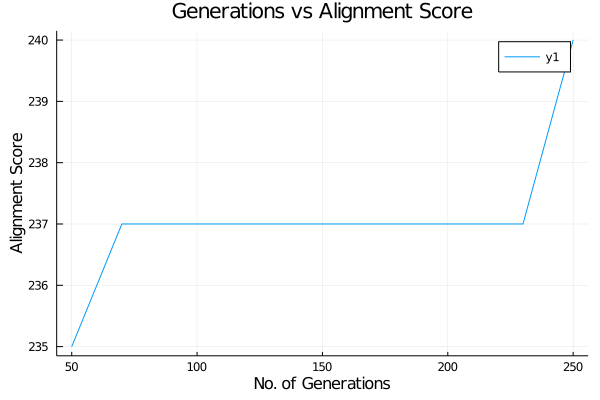

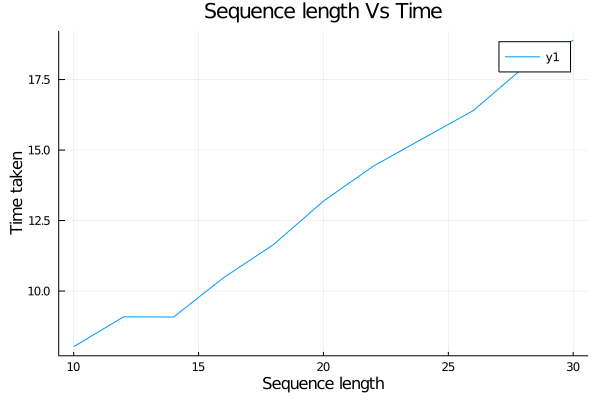

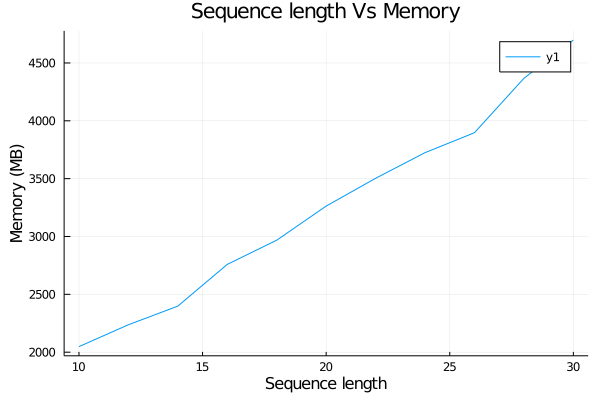

In [52]:
function plot_graphs()
    population_size = 100
    num_of_generations = 250
    mutation_prob = 0.2
    dna_length = 20
    num_of_sequences = 10
    time_taken=[]
    sequences = generate_dna_sequences(num_of_sequences,dna_length)
    generations, align_score = NSGA_Experiment(sequences, population_size, num_of_generations,mutation_prob)
    for g in 50:20:250
        curr_time=0
        curr_time = @timed begin
            best_sol = NSGA(sequences, population_size, g, mutation_prob)
        end
        append!(time_taken,curr_time[2])
    end
    sequence_time=[]
    sequence_memory=[]
    sequence_length=[]
    for s in 10:2:30
        sequences = generate_dna_sequences(num_of_sequences,s)
        time_memory = @timed begin
            NSGA(sequences, population_size, num_of_generations, mutation_prob)
        end
        append!(sequence_time, time_memory[2])
        append!(sequence_memory, (time_memory[3]/1000000))
        append!(sequence_length, s)
    end
    p1 = plot( generations, time_taken, ylabel = "Time taken", xlabel = "No. of Generations", title = "Generations Vs Time")
    p2 = plot(generations, align_score, ylabel = "Alignment Score", xlabel = "No. of Generations", title = "Generations vs Alignment Score")
    p3 = plot(sequence_length,sequence_time, ylabel = "Time taken", xlabel = "Sequence length", title = "Sequence length Vs Time")
    p4 = plot(sequence_length, sequence_memory, ylabel = "Memory (MB)", xlabel = "Sequence length", title = "Sequence length Vs Memory")
    display(p1)
    display(p2)
    display(p3)
    display(p4)
end
#plot_graphs()


## Running algorithm on the BAliBASE dataset

In [59]:
function generate_initial_population_from_align(population_count,alignments) 
    without_crossover = length(alignments)
    
    population_string = []
    population_coded = []
    
    
    for i in 1:without_crossover
        coded_chromosome = codify_chromosome(alignments[i])
        push!(population_coded,coded_chromosome)
        push!(population_string,alignments[i])
    end
    
    with_crossover = (population_count - without_crossover)/2
    for i in 1:with_crossover
        random1 = Int(rand(1:without_crossover))
        random2 = Int(rand(1:without_crossover))
        crossover_string, crossover_coded = crossover(population_string[random1],population_coded[random1],population_string[random2],population_coded[random2])
        population_string = vcat(population_string,crossover_string)
        population_coded = vcat(population_coded,crossover_coded)
    end
    
    return population_string, population_coded
end   


function NSGA_for_balibase(input_alignments, population_size, num_of_gen, pmut)
    alignments, codes = generate_initial_population_from_align(population_size,input_alignments)
    
    P = Vector{Individual}(undef, 2*population_size)    # Whole population 
    
    for i in 1:population_size                                # Create Initial population
        P[i] = Individual(alignments[i],codes[i], calculate_fitness_score(alignments[i])) 
        P[population_size+i] = deepcopy(P[i])
    end
    
    calculate_Pareto_Fronts!(view(P, 1:population_size))
    
    for gen in 1:num_of_gen
        for i = 1:2:population_size
            
            pa = tournament_selection(P)
            pb = tournament_selection(P)
            
            childs_align, childs_codification = crossover(pa.align, pa.codification, pb.align, pb.codification)
            
            if rand() < pmut
                childs_align[1],childs_codification[1] = mutation(childs_align[1],childs_codification[1])
            end
                
            if rand() < pmut
                childs_align[2], childs_codification[2] = mutation(childs_align[2],childs_codification[2])
            end
            
            P[population_size+i] = Individual(childs_align[1],childs_codification[1], calculate_fitness_score(childs_align[1])) 
            P[population_size+i+1] = Individual(childs_align[2],childs_codification[2], calculate_fitness_score(childs_align[2])) 
            
        end
        calculate_Pareto_Fronts!(P)
        
        sort!(P, by = x -> x.rank, alg = Base.Sort.QuickSort)
        
        let f::Int = 1
            ind = 0
            indnext = findlast(x -> x.rank == f, P)
            while 0 < indnext <= population_size
                ind = indnext
                f += 1
                indnext = findlast(x -> x.rank == f, P)
            end
            indnext == 0 && (indnext = length(P))
            crowding_distance_sorting!(view(P, ind+1:indnext))
            sort!(view(P, (ind + 1):indnext), by = x -> x.crowding, rev = true, alg = PartialQuickSort(population_size - ind))
            
        end
        
    end
    optimal_sols = filter(x -> x.rank == 1, view(P, 1:population_size))
    
    best_sol = optimal_sols[1]
    for i in 2:length(optimal_sols)
        if optimal_sols[i].y[2] > best_sol.y[2]
             best_sol = optimal_sols[i]
        end 
    end
    
    return best_sol
    
end

NSGA_for_balibase (generic function with 1 method)

In [62]:
# Experiments for the result section

function sop(sequences)
    t = length(sequences)
    k = length(sequences[1])
    score = 0
    total = 0
    for i=1:t
        A = sequences[i]
        for j=i+1:t
            B = sequences[j]
            for idx = 1:k
                if A[idx] == B[idx] && A[idx] != '-'
                    score += 1
                end
                total += 1
            end
        end
    end
    return score
end

function experiment(version_name)
    release_dir = "bb3_dataset\\"*version_name
    align_dir = "bb3_aligned\\"*version_name
    
    files = readdir(release_dir)
    
    aligned_files = [".msf_tfa",".tfa_clu",".tfa_fsa",".tfa_kalign",".tfa_mafft",".tfa_muscle",".tfa_probcons",".tfa_retalign"]
    
    population_size = 100
    num_of_generations = 300
    mutation_prob = 0.5
    
    for file_name in files
        if file_name[end-3:end] != ".tfa"
           continue 
        end
        
        alignments = []
        
        for af in aligned_files
            name = align_dir*"\\"*file_name[1:end-4]*af
            _, sequences = read_input(name)
            push!(alignments, sequences)
            score = sop(sequences)
            println(file_name[1:end-4]*af, " : ", score)
        end
        
        optimal_align = NSGA_for_balibase(alignments, population_size, num_of_generations, mutation_prob).align
        score = sop(optimal_align)
        
        println(file_name, " : ", round(score, digits=4))
        
        println("-----------------------------------------------------")
    end
    
end

experiment("RV11")
#experiment("RV12")
#experiment("RV20")
#experiment("RV30")
#experiment("RV40")
#experiment("RV50")

BB11001.msf_tfa : 94
BB11001.tfa_clu : 95
BB11001.tfa_fsa : 92
BB11001.tfa_kalign : 102
BB11001.tfa_mafft : 102
BB11001.tfa_muscle : 100
BB11001.tfa_probcons : 98
BB11001.tfa_retalign : 120
BB11001.tfa : 126.0
-----------------------------------------------------
BB11013.msf_tfa : 68
BB11013.tfa_clu : 74
BB11013.tfa_fsa : 23
BB11013.tfa_kalign : 73
BB11013.tfa_mafft : 88
BB11013.tfa_muscle : 87
BB11013.tfa_probcons : 71
BB11013.tfa_retalign : 116
BB11013.tfa : 121.0
-----------------------------------------------------
BB11021.msf_tfa : 128
BB11021.tfa_clu : 97
BB11021.tfa_fsa : 109
BB11021.tfa_kalign : 141
BB11021.tfa_mafft : 152
BB11021.tfa_muscle : 147
BB11021.tfa_probcons : 142
BB11021.tfa_retalign : 160
BB11021.tfa : 167.0
-----------------------------------------------------
BB11022.msf_tfa : 53
BB11022.tfa_clu : 60
BB11022.tfa_fsa : 17
BB11022.tfa_kalign : 65
BB11022.tfa_mafft : 102
BB11022.tfa_muscle : 86
BB11022.tfa_probcons : 76
BB11022.tfa_retalign : 122
BB11022.tfa : 127.0
